# Build a Traffic Sign Recognition Classifier Deep Learning

`Note` : Code and Markdown cells can be executed using the Shift + Enter keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

*Package requirement : Tensorflow 2 with Keras, Anaconda + Python 3 + Numpy

In this tuturial, we will implementer GoogLeNet, the winner of ILSVRS 2014 challenged by pushing the top-five errore rate below 7 %.

## Load and Visualize the German Traffic Signs Dataset.

In [15]:
# Load pickled data
import pickle
import numpy

# TODO: Fill this in based on where you saved the training and testing data

training_file   = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file    = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels'] # training dataset
X_valid, y_valid = valid['features'], valid['labels'] # validation dataset used in training phase
X_test, y_test   = test['features'], test['labels']   # test dataset
n_classes        = len(numpy.unique(y_train))

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape    : {}".format(X_train[0].shape))
print()
print("Training Set   : {} samples".format(len(X_train)))
print("Validation Set : {} samples".format(len(X_valid)))
print("Test Set       : {} samples".format(len(X_test)))
print('n_classes      : {}'.format(n_classes))
#X_train[0].shape
X_train.shape


Image Shape    : (32, 32, 3)

Training Set   : 34799 samples
Validation Set : 4410 samples
Test Set       : 12630 samples
n_classes      : 43


(34799, 32, 32, 3)

We always use the dataset by German Traffic Signs Dataset from INI.

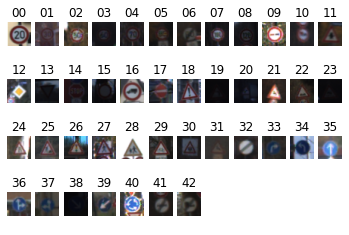

In [2]:
import matplotlib.pyplot as plot
%matplotlib inline
rows, cols   = 4, 12
fig, axes    = plot.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes :
        X_train_of_class = X_train[y_train == idx]
        #X_train_0       = X_train_of_class[numpy.random.randint(len(X_train_of_class))]
        X_train_0        = X_train_of_class[0]
        ax.imshow(X_train_0)
        ax.set_title('{:02d}'.format(idx))
        ax.axis('off')
        plot.setp(ax.get_xticklabels(), visible=False)
        plot.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.axis('off')
#
plot.draw()
fig.savefig('figures/' + 'sample_representative' + '.jpg', dpi=700)

## Implementation of GoogLeNet

In the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems by Aurélien Géron" `https://www.amazon.fr/dp/B07XGF2G87`, GoogLeNet is expalained in details. A significant particularity of GoogLeNet is the application of a set of Convolutional Neural Networks with Depthwise Concatenation layer, called Inception module :

<img src="figures/inception_module.png" alt="Drawing" style="width: 350px;"/>

>Source : Aurélien Géron, "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems", page 467, Figure 14-13. 

GoogLeNet is very deep, which could be counted as ~40 stages - when each Inception module is considered as a 3-stages stack and ~2592 layers in total.

<img src="figures/GoogLeNet.png" alt="Drawing" style="width: 450px;"/>

>Source : Aurélien Géron, "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems", page 468, Figure 14-14. 

We also can find an implementation of GoogLenet with Tensorflow and Keras by Scylla on Kaggle :

>https://www.kaggle.com/luckscylla/googlenet-implementation

In [5]:
### Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


In [4]:
def Inception(x, filter_sizes):
    #stack1 Conv2D 1x1
    stack1 = Conv2D(filter_sizes[0], kernel_size=(1,1), strides=(1,1), padding ='same', activation='relu')(x)
    #stack2 Conv2D 1x1 + 3x3
    stack2 = Conv2D(filter_sizes[1][0], kernel_size=(1,1), strides=(1,1), padding ='same', activation='relu')(x)
    stack2 = Conv2D(filter_sizes[1][1], kernel_size=(3,3), strides=(1,1), padding ='same', activation='relu')(stack2)
    #stack3 Conv2D 1x1 + 5x5
    stack3 = Conv2D(filter_sizes[2][0], kernel_size=(1,1), strides=(1,1), padding ='same', activation='relu')(x)
    stack3 = Conv2D(filter_sizes[2][1], kernel_size=(5,5), strides=(1,1), padding ='same', activation='relu')(stack3)
    #stack4 MaxPool 3x3 + Conv2D 1x1
    stack4 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding ='same')(x)
    stack4 = Conv2D(filter_sizes[3], kernel_size=(1,1), strides=(1,1), padding ='same', activation='relu')(stack4)
    #concatenate by last axis(axis=-1)
    return Concatenate(axis=-1)([stack1, stack2, stack3, stack4])

In [5]:
#GoogLeNet model
layer_in           = Input(shape=(32,32,1), name='image_in')
# layer              = BatchNormalization()(layer_in)

#1st stage Conv2D 7x7 + MaxPool 3x3 + Normalization
layer              = Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same', activation='relu')(layer_in)
layer              = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)
layer              = BatchNormalization()(layer)

#2nd stage Conv2D 1x1 + Conv2D 3x3 + Normalization + MaxPool
layer              = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu')(layer)
layer              = Conv2D(192, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(layer)
layer              = BatchNormalization()(layer)
layer              = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

#3rd stage x2 Inception + MaxPool
layer              = Inception(layer, filter_sizes=[64,  (96,128), (16,32), 32])
layer              = Inception(layer, filter_sizes=[128,  (128,192), (32,96), 64])
layer              = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

#4th stage x5 Inception + MaxPool
layer              = Inception(layer, filter_sizes=[192,  (96,208), (16,48), 64])
layer              = Inception(layer, filter_sizes=[160,  (112,224), (24,64), 64])
layer              = Inception(layer, filter_sizes=[128,  (128,256), (24,64), 64])
layer              = Inception(layer, filter_sizes=[112,  (144,288), (32,64), 64])
layer              = Inception(layer, filter_sizes=[256,  (160,320), (32,128), 128])
layer              = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

#5th stage x2 Inception + GlobalAveragePool
layer              = Inception(layer, filter_sizes=[256,  (160,320), (32,128), 128])
layer              = Inception(layer, filter_sizes=[384,  (192,384), (48,128), 128])
layer              = GlobalAveragePooling2D()(layer)

#Dropout + Fully Connected for classification
layer              = Dropout(0.01)(layer)
layer              = Dense(units=129, activation='linear')(layer)
layer_out          = Dense(units=n_classes, activation='softmax')(layer)

#GoogLeNet
GoogLeNet          = keras.Model(layer_in, layer_out, name="GoogLeNet")

Model: "GoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   3200        image_in[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8, 8, 64)     256         max_pooling2d[0][0]              
__________________________________________________________________________________________

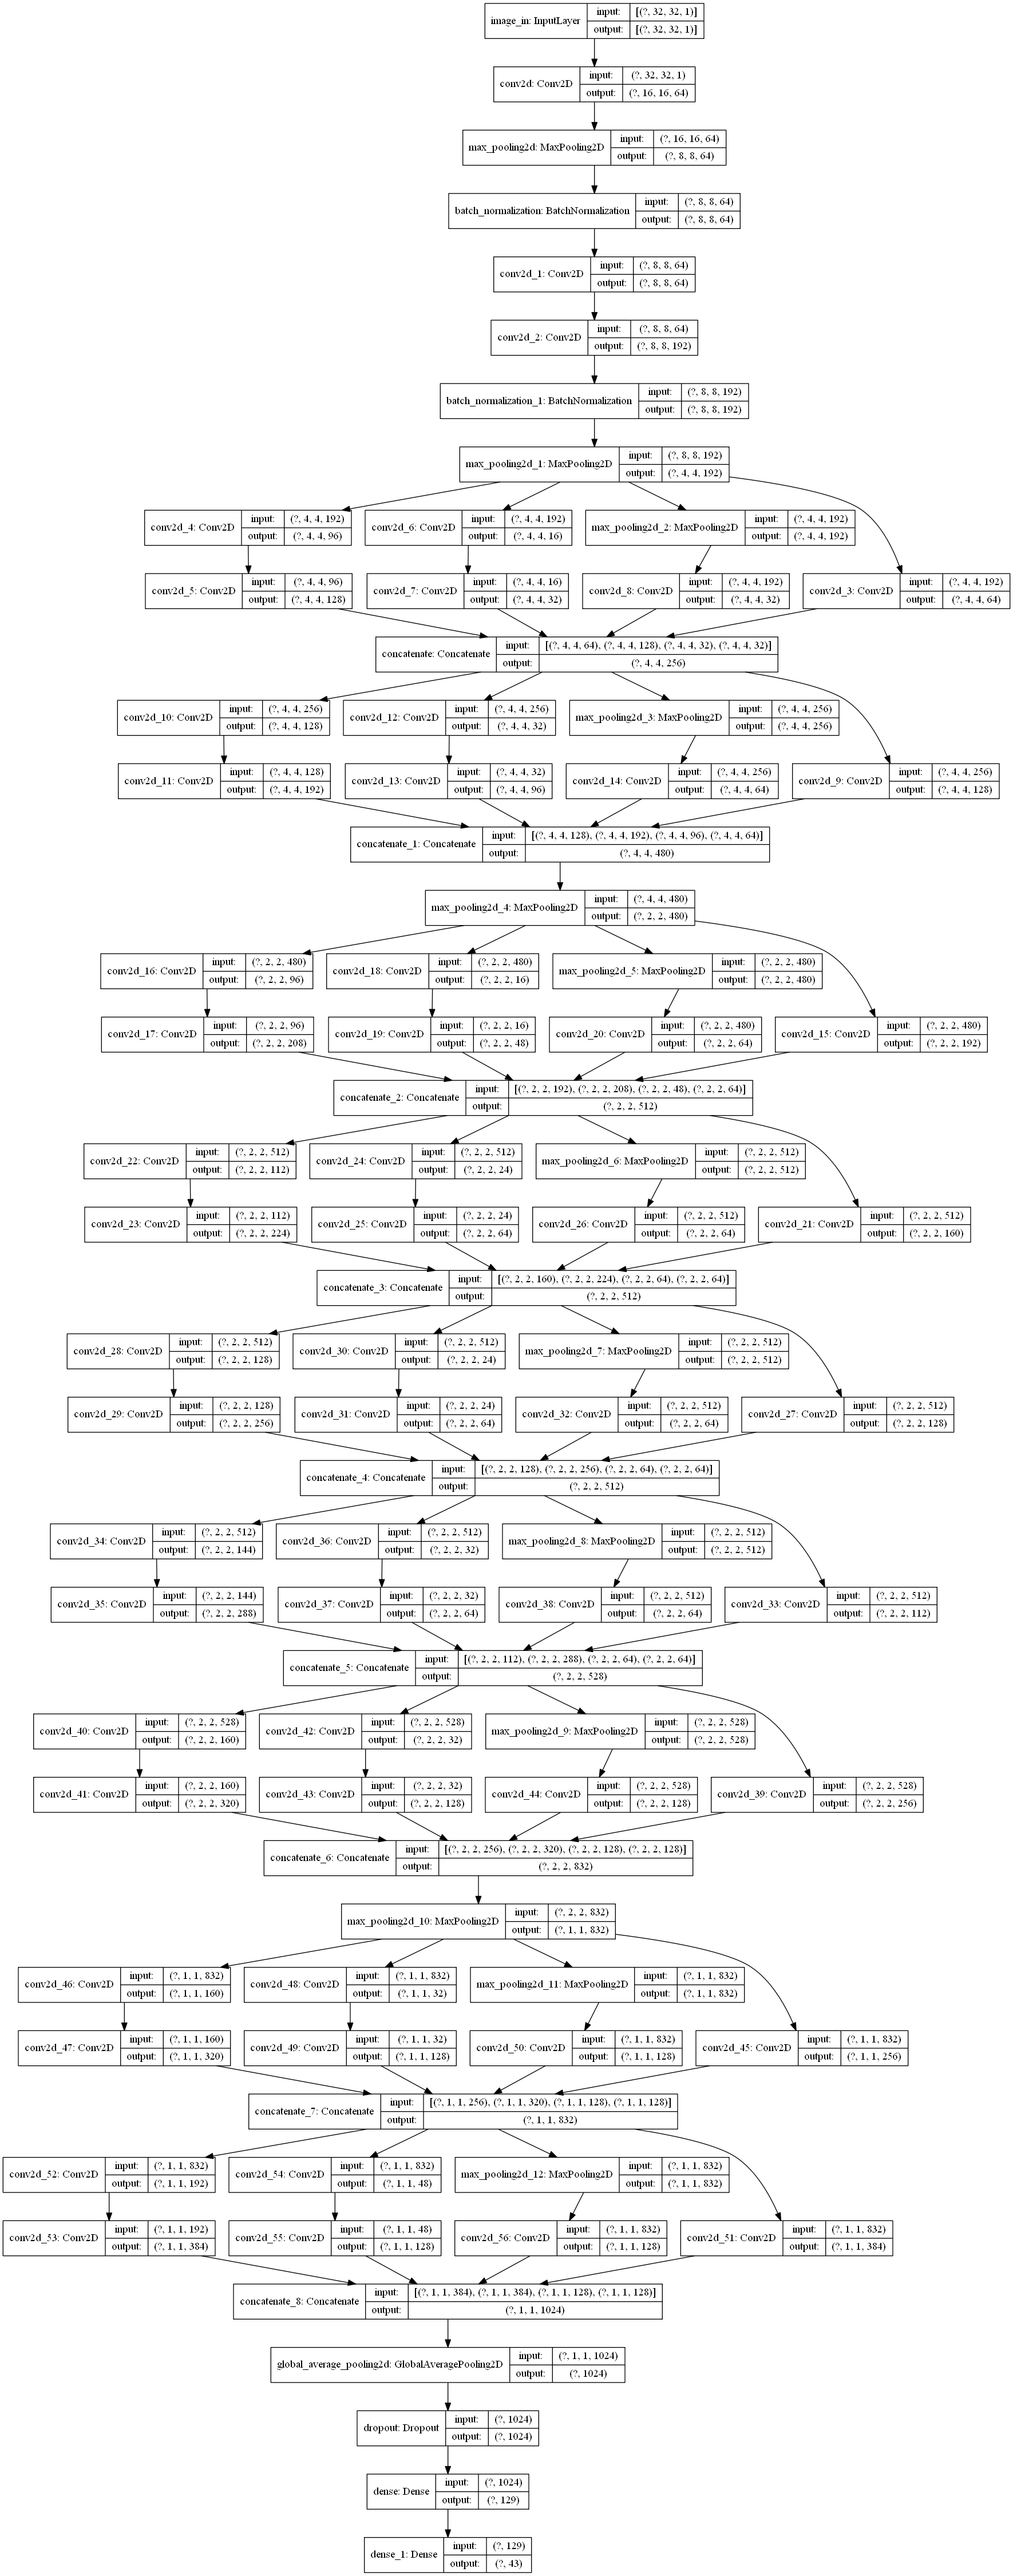

In [6]:
#Plot model architecture
GoogLeNet.summary()
keras.utils.plot_model(GoogLeNet, "figures/GoogLeNet.png", show_shapes=True)

### Input preprocessing

#### Color-Space
Pierre Sermanet and Yann LeCun used YUV color space with almost of processings on Y-channel (Y stands for brightness, U and V stand for Chrominance).  

Many works in computer vision relay on gray-scale because human can naturally classifier object in gray-scale and a frame in gray-scale could save memory and keep easier for normalization phase in data pre-processing. However, I think that we lost information in grayscale, so I will use HSL color space to have intuitively the perception of Hue, Saturation and Lightness in some cases it could improve the final accuracy. I will sacrifice the performance and memory consumption of my algorithm to have more information, and hopefully better accuracy (it could engender over-fitting issues also in worst cases, let's see !) during the processing.  


#### Normalization
Each channel of an image is in uint8 scale (0-255), we will normalize each channel to 0-1.  
Generally, we normalize data to get them center around -1 and 1, to prevent numrical errors due to many steps of matrix operation. Imagine that we have 255x255x255x255xk operation, it could give a huge numerical error if we just have a small error in k.  

In [2]:
import cv2
def input_normalization(X_in):    
    X       = numpy.array([numpy.expand_dims(cv2.cvtColor(image_ij, cv2.COLOR_RGB2YUV)[:,:,0],2) for image_ij in X_in])
    X       = numpy.array([numpy.expand_dims(cv2.equalizeHist(numpy.uint8(image_ij)),2) for image_ij in X])
    X       = numpy.float32(X/255.0)
    #X       = (X-128)/128.0
    # nomalize features
    X -= numpy.mean(X, axis=0)
    X /= (numpy.std(X, axis=0) + numpy.finfo('float32').eps)
    return X
# def input_normalization(X_in):    
#     X       = numpy.array([cv2.cvtColor(image_ij, cv2.COLOR_RGB2HLS) for image_ij in X_in])
#     return X

In [6]:
# normalization of dataset
X_train_norm     = input_normalization(X_train)
X_valid_norm     = input_normalization(X_valid)

# one-hot matrix
y_train_onehot   = keras.utils.to_categorical(y_train, n_classes)
y_valid_onehot   = keras.utils.to_categorical(y_valid, n_classes)

In [13]:
print(X_train_norm.shape)
print('{0:.4g}'.format(numpy.max(X_train_norm)))
print('{0:.3g}'.format(numpy.min(X_train_norm)))

(34799, 32, 32, 1)
2.264
-2.78


### Training Pipeline
_Optimizer : we use Adam optimizer, better than SDG (Stochastic Gradient Descent)  
_Loss function : Cross Entropy by category  
_Metrics : accuracy  
*learning rate 0.001 work well with our network, it's better to try with small laerning rate in the begining.

In [14]:
rate = 0.001

GoogLeNet.compile(
    optimizer=keras.optimizers.Nadam(learning_rate = rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"])

### Real-time data augmentation

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            rotation_range=15.0,
            zoom_range=0.2,
            width_shift_range=0.1,
            height_shift_range=0.1,
            featurewise_center=False,
            featurewise_std_normalization=False,
            horizontal_flip=False)

#datagen.fit(X_train_norm)

#### Example of an augmented image

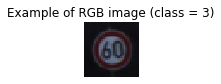

In [21]:
# take a random image from the training set
img_rgb = X_train[6500]

# plot the original image
import matplotlib.pyplot as plot
fig = plot.figure(figsize=(1,1))
plot.imshow(img_rgb)
plot.title('Example of RGB image (class = {})'.format(y_train[6500]))
plot.axis('off')
plot.show()

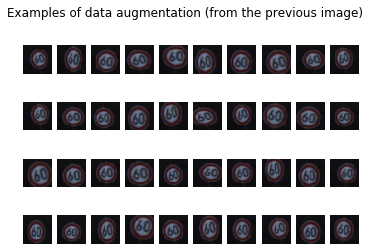

In [22]:
# plot some augmented images
rows, cols    = 4, 10
fig, ax_array = plot.subplots(rows, cols)
for ax in ax_array.ravel():
    augmented_img, _ = datagen.flow(numpy.expand_dims(img_rgb, 0), y_train[6500:6501]).next()
    ax.imshow(numpy.uint8(numpy.squeeze(augmented_img)))
    ax.axis('off')
# plot.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
# plot.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plot.suptitle('Examples of data augmentation (from the previous image)')
plot.show()

### Train the Model


In [16]:
EPOCHS          = 30
BATCH_SIZE      = 32
STEPS_PER_EPOCH = int(len(X_train_norm)/BATCH_SIZE)

history         = GoogLeNet.fit(
                datagen.flow(X_train_norm, y_train_onehot, batch_size=BATCH_SIZE,shuffle=True),
                validation_data=(X_valid_norm, y_valid_onehot),    
                shuffle=True,
                steps_per_epoch=STEPS_PER_EPOCH,
                epochs=EPOCHS)

GoogLeNet.save("GoogLeNet.h5")

  ...
    to  
  ['...']
Train for 1087 steps, validate on 4410 samples
Epoch 1/30
1087/1087 [==============================] - 179s 165ms/step - loss: 2.5598 - accuracy: 0.2086 - val_loss: 1.9059 - val_accuracy: 0.2955
Epoch 2/30
1087/1087 [==============================] - 162s 149ms/step - loss: 1.5805 - accuracy: 0.4512 - val_loss: 1.4215 - val_accuracy: 0.5175
Epoch 3/30
1087/1087 [==============================] - 139s 128ms/step - loss: 1.0916 - accuracy: 0.6171 - val_loss: 0.8811 - val_accuracy: 0.6796
Epoch 4/30
1087/1087 [==============================] - 146s 134ms/step - loss: 0.7937 - accuracy: 0.7334 - val_loss: 0.6170 - val_accuracy: 0.7993
Epoch 5/30
1087/1087 [==============================] - 140s 129ms/step - loss: 0.6152 - accuracy: 0.8022 - val_loss: 0.5236 - val_accuracy: 0.8079
Epoch 6/30
1087/1087 [==============================] - 143s 131ms/step - loss: 0.5067 - accuracy: 0.8409 - val_loss: 0.5124 - val_accuracy: 0.8442
Epoch 7/30
1087/1087 [==================

### Evaluate the Model
We will use the test dataset to evaluate classification accuracy.

In [7]:
#Normalize test dataset
X_test_norm   = input_normalization(X_test)
#One-hot matrix
y_test_onehot = keras.utils.to_categorical(y_test, n_classes)

In [8]:
#Load saved model
reconstructed_LeNet_Model = keras.models.load_model("GoogLeNet.h5")

#Evaluate and display the prediction
result                    = reconstructed_LeNet_Model.evaluate(X_test_norm,y_test_onehot)
dict(zip(reconstructed_LeNet_Model.metrics_names, result))

12630/12630 [==============================] - 14s 1ms/sample - loss: 0.3807 - accuracy: 0.9246


{'loss': 0.38072624774863584, 'accuracy': 0.9246239}

In [10]:
pickle.dump(history.history, open( "history_GoogLeNet.p", "wb" ))

NameError: name 'history' is not defined

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

with open("history_GoogLeNet.p", mode='rb') as f:
    history_ = pickle.load(f)


Plot of training error over 30 epochs:


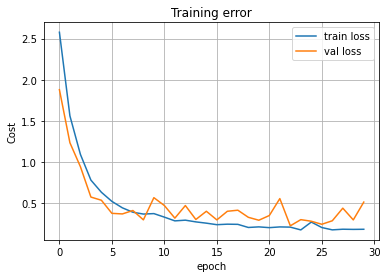

In [13]:
# Plot training error.
print('\nPlot of training error over 30 epochs:')
fig = plt.figure()
plt.title('Training error')
plt.ylabel('Cost')
plt.xlabel('epoch')
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.grid()
plt.show()
fig.savefig('figures/Training_loss_GoogLeNet.png', dpi=500)


Plot of training accuracy over 30 epochs:


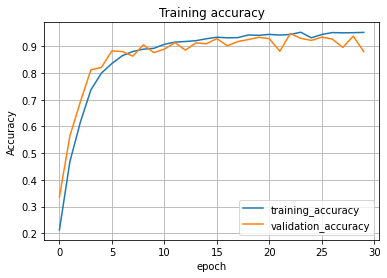

In [14]:
# Plot training error.
print('\nPlot of training accuracy over 30 epochs:')
fig = plt.figure()
plt.title('Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history_['accuracy'])
plt.plot(history_['val_accuracy'])
plt.legend(['training_accuracy', 'validation_accuracy'], loc='lower right')
plt.grid()
plt.show()
fig.savefig('figures/Training_accuracy_GoogLeNet.png', dpi=500)

Once the model trained, we can call saved model "GoogLeNet.h5" for classifying of input traffic signs later.

### Prediction of test dataset with trained model
We will use the test dataset to test trained model's prediction of instances that it has never seen during training.

In [3]:
print("Test Set       : {} samples".format(len(X_test)))
print('n_classes      : {}'.format(n_classes))
X_test.shape

Test Set       : 12630 samples
n_classes      : 43


(12630, 32, 32, 3)

In [7]:
#Normalize test dataset
X_test_norm   = input_normalization(X_test)
#One-hot matrix
y_test_onehot = keras.utils.to_categorical(y_test, n_classes)

In [8]:
#Load saved model
reconstructed = keras.models.load_model("GoogLeNet.h5")

#Evaluate and display the prediction
prediction_performance    = reconstructed.evaluate(X_test_norm,y_test_onehot)
dict(zip(reconstructed.metrics_names, prediction_performance))

395/395 [==============================] - 8s 20ms/step - loss: 0.3807 - accuracy: 0.9246


{'loss': 0.38072630763053894, 'accuracy': 0.9246239066123962}

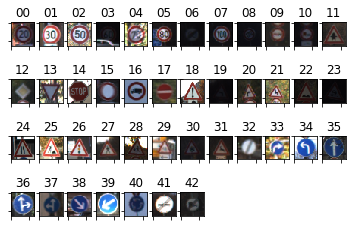

In [9]:
import matplotlib.pyplot as plot
%matplotlib inline
rows, cols   = 4, 12
fig, axes    = plot.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes :
        X_test_of_class = X_test[y_test == idx]
        #X_train_0       = X_train_of_class[numpy.random.randint(len(X_train_of_class))]
        X_test_0        = X_test_of_class[0]
        ax.imshow(X_test_0)
        ax.set_title('{:02d}'.format(idx))
        plot.setp(ax.get_xticklabels(), visible=False)
        plot.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.axis('off')
#
plot.draw()
fig.savefig('figures/' + 'test_representative' + '.jpg', dpi=700)

In [10]:
#### Prediction for all instances inside the test dataset
y_pred_proba   = reconstructed.predict(X_test_norm)
y_pred_class   = y_pred_proba.argmax(axis=-1)

### Showing prediction results for 10 first instances
for i, pred in enumerate(y_pred_class):
    if i <= 10:        
        print('Image {} - Target = {}, Predicted = {}'.format(i, y_test[i], pred))
    else:
        break

Image 0 - Target = 16, Predicted = 16
Image 1 - Target = 1, Predicted = 1
Image 2 - Target = 38, Predicted = 38
Image 3 - Target = 33, Predicted = 33
Image 4 - Target = 11, Predicted = 11
Image 5 - Target = 38, Predicted = 38
Image 6 - Target = 18, Predicted = 18
Image 7 - Target = 12, Predicted = 12
Image 8 - Target = 25, Predicted = 25
Image 9 - Target = 35, Predicted = 35
Image 10 - Target = 12, Predicted = 12


#### confusion_matrix
`column`      : test dataset ground truth labels  
`row`         : prediction labels on test dataset  
`diagonal`    : incremented when prediction matches ground truth label  

In [12]:
confusion_matrix = numpy.zeros([n_classes, n_classes])

In [13]:
for ij in range(len(X_test_norm)):
    if y_test[ij] == y_pred_class[ij]:
        confusion_matrix[y_test[ij],y_test[ij]] += 1
    else:
        confusion_matrix[y_pred_class[ij],y_test[ij]] -= 1

In [14]:
column_label = ['     L % d' % x for x in range(n_classes)]
row_label    = ['     P % d' % x for x in range(n_classes)]

In [15]:
# Plot classe representatives
import matplotlib.pyplot as plot
%matplotlib inline
rows, cols   = 1, 43
fig, axes    = plot.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes :
        X_test_of_class = X_test[y_test == idx]
        X_test_0        = X_test_of_class[0]
        ax.imshow(X_test_0)
        plot.setp(ax.get_xticklabels(), visible=False)
        plot.setp(ax.get_yticklabels(), visible=False)
        # plot.tick_params(axis='both', which='both', bottom='off', top='off',
        # labelbottom='off', right='off', left='off', labelleft='off')
        ax.axis('off')
plot.draw()
fig.savefig('figures/' + 'label_groundtruth' + '.jpg', dpi=3500)

In [16]:
numpy.savetxt("confusion_matrix_GoogLeNet_mod2.csv", confusion_matrix, delimiter=";")

#### Thank to confusion matrix, we could identify where to enhance  
-[x] training dataset  
-[x] real-time data augmentation  
-[x] preprocessing  

*Extract of confusion matrix of classification on test dataset &#8595;*  
<img src="figures/confusion_matrix_googlenet.png" alt="Drawing" style="width: 750px;"/>

### Prediction of new instances with trained model
We will use the test dataset to test trained model's prediction of instances that it has never seen during training.
I used 'softmax' activation in the last layer, so the output prediction is probabilities that input image is belong to a class.

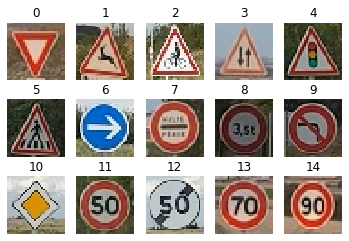

In [5]:
# load french traffic signs
import os
import cv2
import matplotlib.pyplot as plot
dir_frenchsign     = 'french_traffic-signs-data'
images_frenchsign  = [os.path.join(dir_frenchsign, f) for f in os.listdir(dir_frenchsign)]
images_frenchsign  = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in images_frenchsign]

# plot new test images
fig, axes          = plot.subplots(3, int(len(images_frenchsign)/3))
plot.title('French traffic signs')
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images_frenchsign[i])
    ax.set_title('{}'.format(i))
    plot.setp(ax.get_xticklabels(), visible=False)
    plot.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis('off')
plot.draw()
fig.savefig('figures/' + 'french_sign' + '.jpg', dpi=700)

*German traffic signs from INI dataset, in stardard form &#8595;*  
<img src="figures/german_sign.jpg" alt="Drawing" style="width: 600px;"/>

In [6]:
# manually label for these new images
y_frenchsign       = [13, 31, 29, 24, 26, 27, 33, 17, 15, 34, 12, 2, 2, 4, 2]
n_classes          = 43

# when a sign doesn't present in our training dataset, we'll try to find a enough 'similar' sign to label it.

# image 2 : class 29 differed 
# image 3 : class 24, double-sens not existed 
# image 5 : class 27 differed
# image 6 : class 33 not existed 
# image 7 : class 17, halte-péage not existed 
# image 8 : class 15, 3.5t limit not existed 
# image 9 : class 15, turn-left inhibition not existed
# image 12 : class 2, ending of 50kmh speed-limit not existed
# image 14 : class 2, 90kmh speed-limit not existed

#### it's really intersting that somes common french traffic signs are not present in INI German traffic signs dataset or differed
Whatever our input - evenif it's not present in the training dataset, by using softmax activation our classififer can not say that 'this is a new traffic sign that it doesn't recognize' (sum of probability across all classes is 1), it's just try to find class that probably suit for the input.

In [7]:
#Normalize the dataset
X_frenchsign_norm        = input_normalization(images_frenchsign)
#One-hot matrix
y_frenchsign_onehot      = keras.utils.to_categorical(y_frenchsign, n_classes)

#Load saved model
reconstructed            = keras.models.load_model("GoogLeNet.h5")

#Evaluate and display the prediction performance
prediction_performance   = reconstructed.evaluate(X_frenchsign_norm, y_frenchsign_onehot)
dict(zip(reconstructed.metrics_names, prediction_performance))

1/1 [==============================] - 0s 994us/step - loss: 3.6368 - accuracy: 0.4667


{'loss': 3.6368494033813477, 'accuracy': 0.46666666865348816}

In [8]:
#### Prediction for all instances inside the test dataset
y_pred_proba             = reconstructed.predict(X_frenchsign_norm)
y_pred_class             = y_pred_proba.argmax(axis=-1)

### Showing prediction results
for i, pred in enumerate(y_pred_class):   
    print('Image {} - Target = {}, Predicted = {}'.format(i, y_frenchsign[i], pred))

Image 0 - Target = 13, Predicted = 13
Image 1 - Target = 31, Predicted = 31
Image 2 - Target = 29, Predicted = 28
Image 3 - Target = 24, Predicted = 11
Image 4 - Target = 26, Predicted = 30
Image 5 - Target = 27, Predicted = 27
Image 6 - Target = 33, Predicted = 7
Image 7 - Target = 17, Predicted = 8
Image 8 - Target = 15, Predicted = 3
Image 9 - Target = 34, Predicted = 8
Image 10 - Target = 12, Predicted = 12
Image 11 - Target = 2, Predicted = 2
Image 12 - Target = 2, Predicted = 5
Image 13 - Target = 4, Predicted = 4
Image 14 - Target = 2, Predicted = 2


*French traffic signs to classsify &#8595;*  
<img src="figures/french_sign_compare_german_INI.jpg" alt="Drawing" style="width: 750px;"/>

Top 3 model predictions for image 0 (Target is 13)
   Prediction = 39 with probability 0.0000
   Prediction = 09 with probability 0.0000
   Prediction = 13 with probability 1.0000
Top 3 model predictions for image 1 (Target is 31)
   Prediction = 21 with probability 0.0001
   Prediction = 23 with probability 0.0001
   Prediction = 31 with probability 0.9998
Top 3 model predictions for image 2 (Target is 29)
   Prediction = 27 with probability 0.0245
   Prediction = 24 with probability 0.0902
   Prediction = 28 with probability 0.8490
Top 3 model predictions for image 3 (Target is 24)
   Prediction = 21 with probability 0.0026
   Prediction = 30 with probability 0.0417
   Prediction = 11 with probability 0.9500
Top 3 model predictions for image 4 (Target is 26)
   Prediction = 11 with probability 0.0466
   Prediction = 28 with probability 0.0482
   Prediction = 30 with probability 0.8630
Top 3 model predictions for image 5 (Target is 27)
   Prediction = 28 with probability 0.2012
   Pre

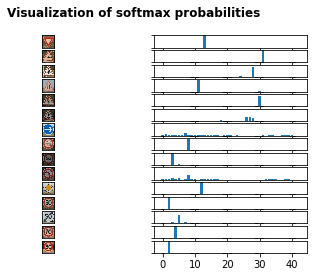

In [9]:
#### plot softmax probs along with traffic sign examples
n_img        = X_frenchsign_norm.shape[0]
fig, axarray = plot.subplots(n_img, 2)
plot.suptitle('Visualization of softmax probabilities', fontweight='bold')
for r in range(0, n_img):
    axarray[r, 0].imshow(numpy.squeeze(images_frenchsign[r]))
    axarray[r, 0].set_xticks([]), axarray[r, 0].set_yticks([])
    plot.setp(axarray[r, 0].get_xticklabels(), visible=False)
    plot.setp(axarray[r, 0].get_yticklabels(), visible=False)
    axarray[r, 1].bar(numpy.arange(n_classes), y_pred_proba[r])
    axarray[r, 1].set_ylim([0, 1])
    plot.setp(axarray[r, 1].get_yticklabels(), visible=False)
plot.draw()
fig.savefig('figures/' + 'french_sign_softmax_visuali' + '.jpg', dpi=700)
    
K = 3
#### print top K predictions of the model for each example, along with confidence (softmax score)    
for i in range(len(images_frenchsign)):
    print('Top {} model predictions for image {} (Target is {:02d})'.format(K, i, y_frenchsign[i]))
    top_3_idx    = numpy.argsort(y_pred_proba[i])[-3:]
    top_3_values = y_pred_proba[i][top_3_idx]    
    for k in range(K):
        print('   Prediction = {:02d} with probability {:.4f}'.format(top_3_idx[k], top_3_values[k]))

*Visualization of softmax probabilities &#8595;*  
<img src="figures/french_sign_softmax_visuali_googlenet.jpg" alt="Drawing" style="width: 750px;"/>